In [0]:
from google.colab import drive

from datetime import datetime
from keras import optimizers
from keras import regularizers
from keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalMaxPooling2D
from keras.models import Model, load_model
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

%matplotlib inline

In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data_dir = '/content/drive/My Drive/Colab Notebooks/Assignment3_Data/Q1'

In [0]:
x_data = np.load(data_dir + '/x_data.npy')
x_orignal_dim = np.load(data_dir + '/x_orignal_dim.npy')
y_data = np.load(data_dir + '/y_data.npy')

In [0]:
# x_data = np.load('x_data.npy')
# y_data = np.load('y_data.npy')

In [0]:
print('Shape of x_data: ', x_data.shape)
print('Shape of y_data: ', y_data.shape)
print('x[0] orignal dimension: ', x_orignal_dim[0])

Shape of x_data:  (10721, 224, 224, 3)
Shape of y_data:  (10721, 6)
x[0] orignal dimension:  [480 640   3]


In [0]:
class_labels = [0, 1, 2]

In [0]:
y_data[0]

array(['Data/0001_m_l_01.jpg', '218', '169', '533', '414', 'Palm\n'],
      dtype='<U27')

In [0]:
y_data_class  = []
y_data_coords = []
factor = []

In [0]:
y_data[0][1:5].astype(float)

array([218., 169., 533., 414.])

In [0]:
i = 0
x1 = 0.0
y1 = 0.0
x2 = 0.0
y2 = 0.0
y_data_len = y_data.shape[0]
for i in range(0, y_data_len):
    if (y_data[i][5] == 'Palm\n'):
        y_data_class.append(0)
    elif (y_data[i][5] == 'veins\n'):
        y_data_class.append(1)
    else: y_data_class.append(2)

    # Normalize Coordinates of bounding Box  
    x1 = (y_data[i][1].astype(float)/x_orignal_dim[i][1].astype(float))
    x2 = (y_data[i][3].astype(float)/x_orignal_dim[i][1].astype(float))
    y1 = (y_data[i][2].astype(float)/x_orignal_dim[i][0].astype(float))
    y2 = (y_data[i][4].astype(float)/x_orignal_dim[i][0].astype(float))
    factor.append(x1 + x2 + y1 +y2)
    y_data_coords.append((x1/factor[i], y1/factor[i], x2/factor[i], y2/factor[i]))

In [0]:
x_orignal_dim[0]

array([480, 640,   3])

In [0]:
print(y_data_coords[0])
print(y_data[0])

(0.14263904034896405, 0.14743729552889862, 0.34874591057797166, 0.3611777535441658)
['Data/0001_m_l_01.jpg' '218' '169' '533' '414' 'Palm\n']


# Data for training the model.
   x_data  
   y_data_class  
   y_data_coords  

y_data_class[0]:  0
y_data_coords[0]:  (0.14263904034896405, 0.14743729552889862, 0.34874591057797166, 0.3611777535441658)


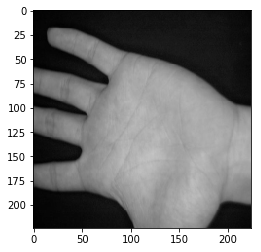

In [0]:
plt.imshow(x_data[0])
print('y_data_class[0]: ', y_data_class[0])
print('y_data_coords[0]: ', y_data_coords[0])

In [0]:
x_data.shape

(10721, 224, 224, 3)

In [0]:
input_shape = (x_data.shape[1], x_data.shape[2], 3)

# Model
Contains ResNet50 to get convolution feature maps  
Global max pooling  
2 heads:  
```
* Classification
* Regression
```

In [0]:
model = ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=input_shape, pooling='None')

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
inp = model.inputs
x = model.output

out1 = Flatten()(x)
out1 = Dense(64, activation='relu')(out1)
out1 = Dense(64, activation='relu')(out1)
out1 = Dense(3, activation='softmax', name='classification')(out1)

out2 = GlobalMaxPooling2D()(x)
out2 = Dense(4, activation='softmax', name='localisation')(out2)

In [0]:
losses = {'classification': 'sparse_categorical_crossentropy', 'localisation': 'logcosh'}
l_weights = {'classification': .5, 'localisation': 2}

In [0]:
model = Model(inputs = inp, outputs = [out1, out2])

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

# Compiling And Traing Model

In [0]:
model.compile(optimizer='adam', loss=losses, loss_weights=l_weights, metrics=['accuracy'])

In [0]:
# callbacks

filepath=data_dir+"/output/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

now = datetime.utcnow().strftime('%Y%m%d%H%M%S')
root_logdir = data_dir + "/output/tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)
tensorboard = TensorBoard(log_dir=logdir,
                         write_graph=True,
                         write_grads=True,
                         batch_size=50,
                         write_images=True)

callbacks_list = [checkpoint, tensorboard]

In [0]:
model.fit(x = x_data,
          y = [y_data_class, y_data_coords],
          batch_size = 50,
          epochs = 150,
          verbose = 1,
          callbacks = callbacks_list,
          validation_split = 0.25,
          shuffle = True)

8040/8040 [==============================] - 110s 14ms/step - loss: 0.0803 - classification_loss: 0.1278 - localisation_loss: 0.0082 - classification_acc: 0.9913 - localisation_acc: 0.6718 - val_loss: 0.0508 - val_classification_loss: 0.0932 - val_localisation_loss: 0.0021 - val_classification_acc: 0.9679 - val_localisation_acc: 0.0884

Epoch 00007: val_loss did not improve from 0.00266
Epoch 8/150

Epoch 00007: val_loss did not improve from 0.00266
Epoch 8/150
8040/8040 [==============================] - 110s 14ms/step - loss: 0.0783 - classification_loss: 0.1112 - localisation_loss: 0.0114 - classification_acc: 0.9925 - localisation_acc: 0.6346 - val_loss: 0.0919 - val_classification_loss: 0.1790 - val_localisation_loss: 0.0012 - val_classification_acc: 0.9519 - val_localisation_acc: 0.0914

Epoch 00008: val_loss did not improve from 0.00266
Epoch 9/150

Epoch 00008: val_loss did not improve from 0.00266
Epoch 9/150
8040/8040 [==============================] - 110s 14ms/step - loss: 

KeyboardInterrupt: ignored

KeyboardInterrupt: ignored

# Loading previously saved weights and evaluating the model

In [0]:
# load weights
model.load_weights(data_dir + "/output/weights.best.hdf5")
# Compile model (required to make predictions)
model.compile(optimizer='adam', loss=losses, loss_weights=l_weights, metrics=['accuracy'])
print("Created model and loaded weights from file")

Created model and loaded weights from file


In [0]:
model.evaluate(x_data, [y_data_class, y_data_coords], verbose=1)

10721/10721 [==============================] - 52s 5ms/step


[0.007101476616047621,
 0.00036338557155159276,
 0.0034598919140204,
 0.9999067251189254,
 0.7628952523085533]

# Testing Model

y_data_class:  0
y_data_coords:  (0.24290942360475756, 0.061299176578225076, 0.41033851784080516, 0.28545288197621227)


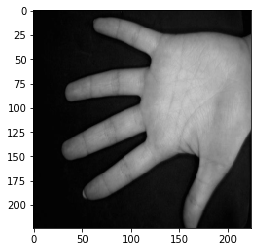

In [227]:
i = 105
plt.imshow(x_data[i])
print('y_data_class: ', y_data_class[i])
print('y_data_coords: ', y_data_coords[i])

In [228]:
result = model.predict(x_data[i].reshape(1, 224, 224, 3), verbose=1)

1/1 [==============================] - 0s 28ms/step


In [0]:
bounding_box_normalised = (result[1]*factor[i])[0] # Normalised
x1 = bounding_box_normalised[0] * x_orignal_dim[i][1]
y1 = bounding_box_normalised[1] * x_orignal_dim[i][0]
x2 = bounding_box_normalised[2] * x_orignal_dim[i][1]
y2 = bounding_box_normalised[3] * x_orignal_dim[i][0]

In [230]:
bounding_box = [x1.astype(int), y1.astype(int), x2.astype(int), y2.astype(int)]
print('Predicted bounding_box: ' ,bounding_box)

Predicted bounding_box:  [269, 124, 552, 351]


In [231]:
print('Orignal Data: ', y_data[i])

Orignal Data:  ['Data/0230_f_l_07.jpg' '354' '67' '598' '312' 'Palm\n']


In [0]:
def DrawBoundingBox(img, coords, thickness):
    print(coords)
    for j in range(coords[0], coords[2]):
      for x in range(0,thickness):
        img[coords[1]+x][j][0] = 0
        img[coords[1]+x][j][1] = 255
        img[coords[1]+x][j][2] = 0

        img[coords[3]-x][j][0] = 0
        img[coords[3]-x][j][1] = 255
        img[coords[3]-x][j][2] = 0
    
    for j in range(coords[1], coords[3]):
      for x in range(0,thickness):
        img[j][coords[0]+x][0] = 0
        img[j][coords[0]+x][1] = 255
        img[j][coords[0]+x][2] = 0

        img[j][coords[2]-x][0] = 0
        img[j][coords[2]-x][1] = 255
        img[j][coords[2]-x][2] = 0

    plt.imshow(img)

(480, 640, 3)


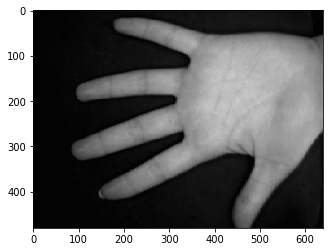

In [253]:
x = x_data[i]
dim = x_orignal_dim[i][1], x_orignal_dim[i][0]
img = cv2.resize(x, dim, interpolation = cv2.INTER_AREA)
plt.imshow(img)
print(img.shape)

In [256]:
# Orignal coordinates
x1 = y_data[i][1].astype(int)
y1 = y_data[i][2].astype(int)
x2 = y_data[i][3].astype(int)
y2 = y_data[i][4].astype(int)
orignal_bb = [x1.astype(int), y1.astype(int), x2.astype(int), y2.astype(int)]
print(bounding_box, orignal_bb)

[269, 124, 552, 351] [354, 67, 598, 312]


[269, 124, 552, 351]
[354, 67, 598, 312]


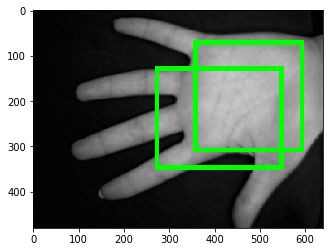

In [257]:
DrawBoundingBox(img, bounding_box, 10)
DrawBoundingBox(img, orignal_bb, 10)

# Intersection Over Union

In [0]:
def bb_intersection_over_union(boxA, boxB):
	
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
 
	# compute the area of intersection rectangle
	if((xB - xA)==0 or (yB - yA)==0):
		iou = 0.0
		return iou
	interArea =  max(0, xB - xA + 1) * max(0, yB - yA + 1)                                                                                                                                                                                                                                                             
 
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
 
	# return the intersection over union value
	return iou




In [0]:
bb_iou = bb_intersection_over_union(bounding_box, orignal_bb)

In [260]:
print(bb_iou)

0.4302776538421938
